# Phish Show Setlist Predictor
## Machine Learning Final Project
### Ido Algom & Natalie Gilboa September 2016

### Introduction

Phish is an American rock and roll band noted for their musical improvisation, extended jams, blending of musical genres, and dedicated fan base. The Band Formed at the University of Vermont in 1983 (with the current line-up solidifying in 1985).

The Mockingbird Foundation is a charitable organization founded by fans of the jam band Phish in 1996 to support music education for children. The website Phish.net is a fan website that formally adopted by The Foundation as a project in 2005. The site had begun in 1991 and served Phish fans for nearly two decades as static HTML pages. It was re-launched as an integrated database - of setlists, song histories, reviews, and more - in fall 2009.

The website contains tables about each song that ever played in show. Every single show the band has been playing during the years has a unique setlist. This information about each song and each show is recorded at the website database for fans. With the website API I managed to get all the songs played at every single show the band has ever played. 

We created a lanuage model which takes a show as a sentence each song is a word in the model. We also kept on the show construction. Most of Phish shows constructed with two (sometimes more) sets of music and an encore. I used these to represent the whole show structure. 

Example of a real show sentence (Ido's first Phish show @ Denver, CO) :
> S1,First Tube,Uncle Pen,Carini,Kill Devil Falls,You Enjoy Myself,Ocelot,Undermind,S2,Runaway Jim,Farmhouse,Alaska,Chalk Dust Torture,Emotional Rescue,Fuck Your Face,ENCORE,Grind,Meatstick,END

> S1 - Set 1, S2 - Set 2, ENCORE - Encore

The code we used to retrive the data from phish.net API is shown below at chapter I.

At this opportunity we wanna thanks phish.net admins who gave me the API key so I can do this very special project.

### Chapter I - Data retriving

Chapter Notes:

- API key has removed due to privacy reasons on GITHUB
- We used commas as seperator between songs so in order to keep things orgenized we hard coded every comma in a song title to single space char. E.g. the song "My Freind, My Freind" -> "My Freind My Friend"
- We deleted every space char not inside song titles. 
- mainfunction is in comment as data set file is alreday located

In [2]:
import json
from urllib import urlopen
import re

yemkey = 'xxxx'


def getAllShows(year_from,year_to):
    l = list()
    for year in range(year_from, year_to+1):
        url = getJsonUrlAllShowsOfYear(year)
        file = getJsonbyUrl(url)
        if type(file) == list:
            for show in file:
                l.append(show['showid'])
    return l


def getJsonUrlAllShowsOfYear(year):
    return "https://api.phish.net/api.js?api=2.0&format=json&method=pnet.shows.query&year=" + str(
        year) + "&apikey=" + yemkey


def getJsonbyUrl(url):
    response = urlopen(url)
    data = response.read().decode("utf-8")
    return json.loads(data)

def getJsonUrlSetlist(showid):
    return "https://api.phish.net/api.js?showid=" + showid + "&api=2.0&format=json&method=pnet.shows.setlists.get&apikey=" + yemkey

def analyzeShow(show):
    show = getJsonbyUrl(getJsonUrlSetlist(show))


def fixSetlist(sl):
    cleanr = re.compile('<.*?>')
    sl = sl.replace("Come On Baby, Let's Go Downtown","Come On Baby Let's Go Downtown")
    sl = sl.replace("My Friend, My Friend","My Friend My Friend")
    sl = sl.replace("Ob-La-Di, Ob-La-Da","Ob-La-Di Ob-La-Da")
    sl = sl.replace("Love Reign O'er Me","Love Reign O'er Me")
    sl = sl.replace("Swing Low, Sweet Chariot","Swing Low Sweet Chariot")
    sl = sl.replace("I'm Blue, I'm Lonesome","I'm Blue I'm Lonesome")
    sl = sl.replace("Set 1:", "S1, ")
    sl = sl.replace("Set 2:", ", S2, ")
    sl = sl.replace("Set 3:", ", S3, ")
    sl = sl.replace("Set 4:", ", S4, ")
    sl = sl.replace("Encore:", ", ENCORE,")
    sl = sl.replace("Encore 2:", ", ENCORE,")
    sl = re.sub(cleanr,'',sl)
    sl = sl.replace(" >",",")
    sl = sl.replace(" ->", ",")
    sl = sl.replace(",  ", ",")
    sl = sl.replace(", ", ",")
    notes = notesNum(sl)
    if notes > 0:
        sl = sl[0:sl.rfind('[1]')]
        for i in range(1,notes+1):
            s = '[' + str(i) + ']'
            sl = sl.replace(s,"")
    sl += ",END"
    return sl


def notesNum(sl):
    end = len(sl)
    i = sl.rfind(']')
    while i > 0:
        if sl[i-1] > '0' and sl[i-1] <= '9':
            return int(sl[i-1])
        else:
            end = i-1
            i = sl.rfind(']',0,end)
    return 0;

def createDataSet(filename,year_from,year_to):
    shows = getAllShows(year_from,year_to)
    filename += '.yem'
    target = open(filename,mode='w')
    for show in shows:
        dataurl = getJsonUrlSetlist(show)
        data = getJsonbyUrl(dataurl)
        setlist = data[0]['setlistdata']
        print(data[0]['showdate'] + data[0]['showid'])
        setlist = fixSetlist(setlist)
        target.write(setlist)
        target.write("\n")


#createDataSet('data_new',1983,2015)

### Chapter II - The Network

Our implementation is based on the [follwing](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/) article. We used the Theano model for this project as following:


#### Imports and consts

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import itertools
import nltk
import sys
import os
import theano
from datetime import datetime
from utils import *
from rnn_theano import RNNTheano, gradient_check_theano
import re, math
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt 

vocabulary_size = 2000
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "S1"
sentence_end_token = "END"

_HIDDEN_DIM = int(os.environ.get('HIDDEN_DIM', '80'))
_LEARNING_RATE = float(os.environ.get('LEARNING_RATE', '0.005'))
_NEPOCH = int(os.environ.get('NEPOCH', '300'))
_MODEL_FILE = os.environ.get('MODEL_FILE')

#### Functions

In [4]:
def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=1, evaluate_loss_after=5):
    # We keep track of the losses so we can plot them later
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Optionally evaluate the loss
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            losses.append((num_examples_seen, loss))
            time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
            print "%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss)
            # Adjust the learning rate if loss increases
            if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                learning_rate = learning_rate * 0.5
                print "Setting learning rate to %f" % learning_rate
            sys.stdout.flush()
            # ADDED! Saving model oarameters
            save_model_parameters_theano("./data/rnn-theano-%d-%d-%s.npz" % (model.hidden_dim, model.word_dim, time), model)
        # For each training example...
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1

def generate_setlist(model):
    # We start the sentence with the start token
    setlist = [song_to_index[sentence_start_token]]
    # Repeat until we get an end token
    while not setlist[-1] == song_to_index[sentence_end_token]:
        next_word_probs = model.forward_propagation(setlist)
        sampled_song = song_to_index[unknown_token]
        # We don't want to sample unknown words
        while sampled_song == song_to_index[unknown_token]:
            samples = np.random.multinomial(1, next_word_probs[-1])
            sampled_song = np.argmax(samples)
        setlist.append(sampled_song)
    setlist_str = [index_to_word[x] for x in setlist]
    return setlist_str

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in vec1.keys()])
    sum2 = sum([vec2[x] ** 2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

#### Main Script

In [5]:
#open the file and split it to sentences
with open("data_new.yem", 'rb') as f:
    shows_data = [line.strip() for line in f]
print("Parsed %d shows." % (len(shows_data)))

Parsed 1758 shows.


In [6]:
# Tokenize the sentences into words
shows_tokenized = [nltk.tokenize.regexp_tokenize(sent, pattern="[\number|\w|'|?|!|.| |/|:|-|(|)]+", gaps=False) for sent in shows_data]

# Count the word frequencies
song_freq = nltk.FreqDist(itertools.chain(*shows_tokenized))
print ("Found %d unique songs." % len(song_freq.items()))

# Prevent blank words in case of enclosed set of words
if vocabulary_size > len(song_freq.items()):
    vocabulary_size = len(song_freq.items())

Found 867 unique songs.


Notes:
- The parsing is regular expression reading all charecters that may appear in a song title.
- Due to the model changes to predict discrete group of songs, randomize has to stay at the limitation of acctual songs the band has in it's bank.

In [7]:
#Get the most common words and build index_to_word and song_to_index vectors
vocab = song_freq.most_common(vocabulary_size)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
song_to_index = dict([(w, i) for i, w in enumerate(index_to_word)])
print("Using vocabulary size %d." % vocabulary_size)
print("\nExample show: '%s'" % shows_data[0])
print("\nExample show after Pre-processing: '%s'" % shows_tokenized[0])

Using vocabulary size 867.

Example show: 'S1,Long Cool Woman in a Black Dress,Proud Mary,In the Midnight Hour,Squeeze Box,Roadhouse Blues,Happy Birthday to You,S2,Scarlet Begonias,Fire on the Mountain,END'

Example show after Pre-processing: '['S1', 'Long Cool Woman in a Black Dress', 'Proud Mary', 'In the Midnight Hour', 'Squeeze Box', 'Roadhouse Blues', 'Happy Birthday to You', 'S2', 'Scarlet Begonias', 'Fire on the Mountain', 'END']'


In [8]:
# Create the training data
X_train = np.asarray([[song_to_index[w] for w in sent[:-1]] for sent in shows_tokenized])
y_train = np.asarray([[song_to_index[w] for w in sent[1:]] for sent in shows_tokenized])

# Print an training data example
x_example, y_example = X_train[5], y_train[5]
print ("x:\n%s\n%s" % (" ".join([index_to_word[x] for x in x_example]), x_example))
print ("\ny:\n%s\n%s" % (" ".join([index_to_word[x] for x in y_example]), y_example))

x:
S1 Anarchy Camel Walk Fire Up the Ganja Skippy the Wondermouse In the Midnight Hour
[0, 274, 161, 716, 392, 364]

y:
Anarchy Camel Walk Fire Up the Ganja Skippy the Wondermouse In the Midnight Hour END
[274, 161, 716, 392, 364, 1]


In [9]:
# Run the model with gradientcheck using the GPU
model = RNNTheano(vocabulary_size, hidden_dim=200)
gradient_check_theano(model, [0,1,2,3], [1,2,3,4])

# Re-Create model parameteres - alreday done
#train_with_sgd(model, X_train, y_train, nepoch=_NEPOCH, learning_rate=_LEARNING_RATE)

load_model_parameters_theano('./data/rnn-theano-200-867-2016-09-13-19-28-06.npz', model)

/Library/Python/2.7/site-packages/theano/scan_module/scan.py:1017: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)
/Library/Python/2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


Performing gradient check for parameter U with size 173400.
Gradient check for parameter U passed.
Performing gradient check for parameter V with size 173400.
Gradient Check ERROR: parameter=V ix=(590, 51)
+h Loss: 27.089568
-h Loss: 27.089568
Estimated_gradient: -0.000000
Backpropagation gradient: -0.000000
Relative Error: 0.022393
Loaded model parameters from ./data/rnn-theano-200-867-2016-09-13-19-28-06.npz. hidden_dim=200 word_dim=867


In [23]:
num_sentences = 10
senten_min_length = 25
string = 'show: '
new_sentences = []
for i in range(num_sentences):
    print(string + str(i+1))
    sent = []
    # We want long sentences, not sentences with one or two words
    while len(sent) < senten_min_length:
        sent = generate_setlist(model)
    new_sentences.append(sent)
    print (", ".join(sent))

show: 1
S1, You Ain't Goin' Nowhere, Wilson, Silent in the Morning, David Bowie, Llama, Memories, Amazing Grace, Cavern, My Favorite Things, Stash, Cavern, Dec 1661, Driver, No Quarter, ENCORE, Sleeping Monkey, Llama, Roll in My Sweet Baby's Arms, Emotional Rescue, Tower Jam, Character Zero, Hold Your Head Up, Possum, END
show: 2
S1, Family Picture, I Didn't Know, Good Times Bad Times, Good Times Bad Times, Taste, Melt the Guns, Willin', Good Times Bad Times, The Star Spangled Banner, The Squirming Coil, I Don't Care, ENCORE, Uncle Pen, Look Out Cleveland, Cavern, Four Strong Winds, Possum, ENCORE, Frankenstein, Sweet Adeline, Sweet Adeline, Guyute, Poor Heart, Free Bird, END
show: 3
S1, David Bowie, Family Picture, Dog Faced Boy, Contact, Wildwood Weed, Twenty Years Later, If I Only Had a Brain, Messin' with The Kid, AC/DC Bag, AC/DC Bag, First Tube, Camel Walk, Sleeping Monkey, Billy Breathes, Joy, Piggies, Amazing Grace, Carini, Alumni Blues, Nellie Kane, Crosseyed and Painless, You

#### Similarity by Cosine

similarity average by cosine similarity:0.500653036531


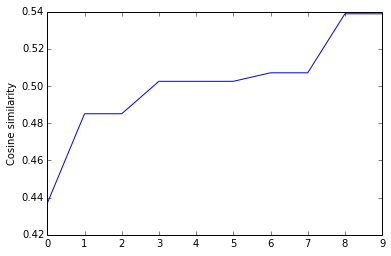

In [24]:
WORD = re.compile(r"[\number|\w|'|?|!|.| |/|:|-|(|)]+")
plot_point = []
temp = 0;
for i in range(len(new_sentences)):
    text1 = ','.join(str(e) for e in new_sentences[i])
    for j in range(len(shows_tokenized)):
        text2 = ','.join(str(e) for e in shows_tokenized[j])
        vector1 = text_to_vector(text1)
        vector2 = text_to_vector(text2)
        if temp < get_cosine(vector1, vector2):
            temp = get_cosine(vector1, vector2)
    plot_point.append(temp)
    
print("similarity average by cosine similarity:" + str(np.mean(plot_point)))
plt.plot(plot_point)
plt.ylabel('Cosine similarity')
plt.show()

#### Similarity By SET

similarity average by SET similarity:0.331097560976


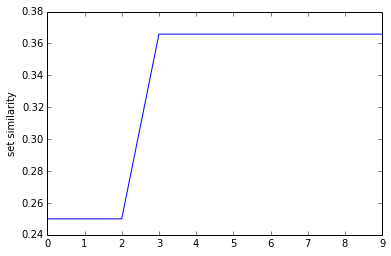

In [25]:
plot_point2 = []
temp = 0;
for i in range(len(new_sentences)):
    text1 = ','.join(str(e) for e in new_sentences[i])
    set_sentence1 = set(text1.split())
    for j in range(len(shows_tokenized)):
        text2 = ','.join(str(e) for e in shows_tokenized[j])
        set_sentence2 = set(text2.split())
        similarity = (1.0 + len(set_sentence1.intersection(set_sentence2))) / (1.0 + max(len(set_sentence1), len(set_sentence2)))
        if temp < similarity:
            temp = similarity
    plot_point2.append(temp)

print("similarity average by SET similarity:" + str(np.mean(plot_point2)))
plt.plot(plot_point2)
plt.ylabel('set similarity')
plt.show()

### Conclusions

- As for a model that was running on a local computer results are satisfying. Need to be considered that the vocabulary is a discrete group of words (songs in our case). As our data-set wasn't huge we could fairly go crazy with parameters and each iteration go through all the list 300 times and have very big hidden layer (n=200)
>     _NEPOCH = int(os.environ.get('NEPOCH', '300'))
       model = RNNTheano(vocabulary_size, hidden_dim=200)

- Procesing time to build the model on Mac Mini 2.4Ghz 16GB RAM was approx. 95 minutes. This had to be done once as all parameters was saved to .npz file. I'm assure that moving to AWS machine would get us higher similarity average.

- Some setlist we've got are not far from reality. Few fun facts
    - Tweezer Reprise was predicted very well. Out of 10 generated shows it was predicted 4 times in it's natural poisiton, right before encore or during encore.
    - We had excpectation that the model would realize the real construction of a show. As out of 1776 shows 1381 had at least two sets. A proper Second generated only once in a proper position. 
    - On the other hand, model learnd **very well** that ENCORE should be placed few words before end of a sentence, but it was still placed in strange positions. 
    - Most generated shows contains at least one obscured song which played by the band only during the 80's or early 90's and still it's in the same list with new songs the band is playing.

- Project was so much fun, We've enjoyed doing the while thing top to bottom. Going through old shows and find out about songs you never heard of is the biggest bonus of the while thing. 

    ![Phish @ San Francisco, CA. Taken By Ido July 2016](phish.png)
                                    Phish @ San Francisco, CA. Taken By Ido July 2016